In [ ]:
!pip install shap

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
import time
import shap

In [3]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [4]:

# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

# scale the data
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev)
X_test = scaler.transform(X_test)

X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42,stratify=y_dev)

## Random Forest

score test: 0.9473684210526315
precision: 0.9434523809523809
recall: 0.9434523809523809
F1score: 0.9434523809523809

confusion matrix:


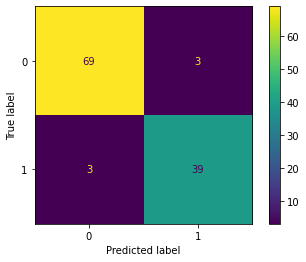

In [29]:
params = {'n_estimators' : [50, 100, 200,300],
          'max_depth' : [3, 10, 20, 40]}


rf = RandomForestClassifier(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 5)

gs1.fit(X_train, y_train)

y_pred = gs1.predict(X_test)

metrics = precision_recall_fscore_support(y_test, y_pred,average='macro')
print("score test:", gs1.score(X_test,y_test))
print("precision:", metrics[0])
print("recall:",metrics[1])
print("F1score:",metrics[2])


print("")
print("confusion matrix:")
confusion_matrix(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred, labels= gs1.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gs1.classes_).plot()
plt.show()

In [30]:
explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

Permutation explainer: 115it [01:44,  1.03it/s]


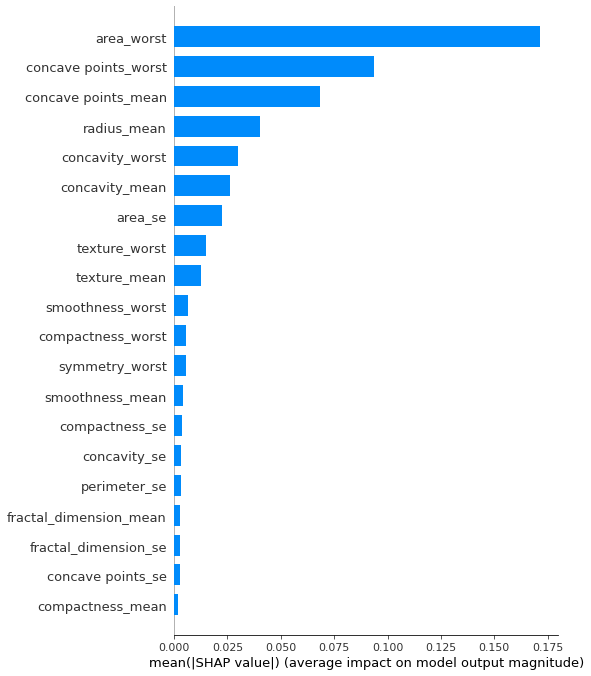

In [31]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## XG boost

Time: 21.30260157585144 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 40}
model performance on test dataset 0.9385964912280702
precision: 0.9323616115296429
recall: 0.9365079365079365
F1score: 0.9343480049362403

confusion matrix:


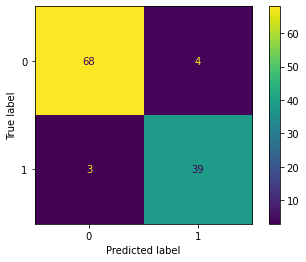

In [12]:


start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,7,100],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingClassifier(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)

metrics = precision_recall_fscore_support(y_test, y_pred,average='macro')

print("precision:", metrics[0])
print("recall:",metrics[1])
print("F1score:",metrics[2])

print("")
print("confusion matrix:")
confusion_matrix(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred, labels=gs2.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gs2.classes_).plot()
plt.show()

In [18]:
explainer = shap.Explainer(gs2.predict, X_test)

shap_values = explainer(X_test)

Permutation explainer: 115it [00:17,  5.92it/s]                         


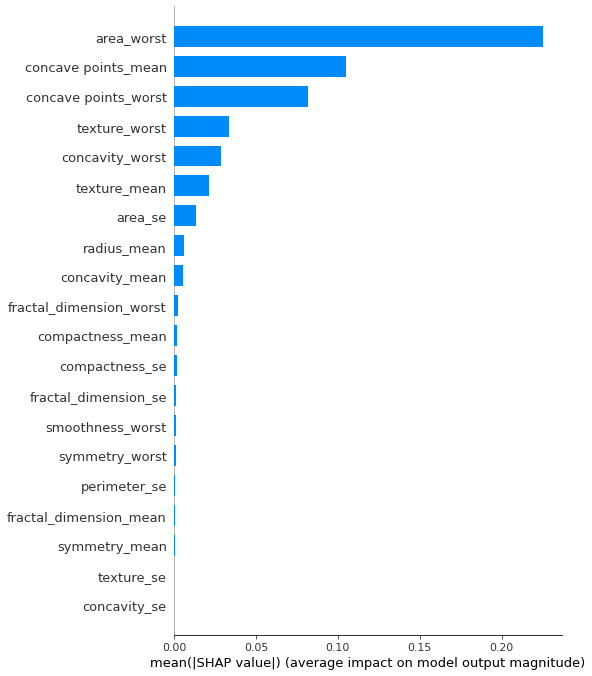

In [23]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

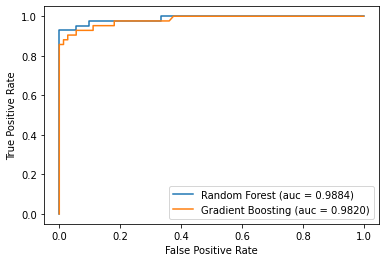

<Figure size 1080x1440 with 0 Axes>

In [33]:
plt.figure(0).clf()

y_pred = gs1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='Random Forest (auc = %0.4f)' % auc)


y_pred = gs2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='Gradient Boosting (auc = %0.4f)' % auc)


plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.figure(figsize=(15, 20))
plt.show()